# Proyek Analisis Data: Brazilian E-Commerce Public Dataset by Olist

**Nama:** Ghiffari Kenang Sagraha \
**Email:** ghiffarisagraha@apps.ipb.ac.id \
**ID Dicoding:** ghiffariks

**catatan**: \
komentar pada kode dilakukan tanpa spasi setelah `#` sebagai bentuk code tanpa AI

# **1. Perkenalan Dataset**

Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Sumber: [kaggle](https://www.kaggle.com/datasets/harunrai/fintech-customer-life-time-value-ltv-dataset/data). Dataset dapat diperoleh dari , seperti public repositories *Kaggle*
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset yang diambil terpenuhi bahwa tidak memiliki label atau kelas
   - **Jumlah Baris**: Dataset yang diambil memiliki sebanyak 7000 baris
   - **Tipe Data**: Telah terpenuhi bahwa dataset memiliki fitur **kategorikal** dan **numerikal**. 

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak digunakan dalam kasus ini

## 1.1 Deskripsi Dataset

FinTech (Digital Wallet) Customer Lifetime Value (LTV) Dataset for Analysis

**Description:** \
This dataset helps to predict the Customer Lifetime Value (LTV) for users of digital wallets, specifically targeting platforms like PayTM and Khalti. The dataset contains about 7,000 samples with 20 rich features capturing customer demographics, transaction history, engagement metrics, app usage patterns, support interactions, etc.

# 2. Import Library

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import VarianceThreshold

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 3. Memuat Dataset

In [3]:
#membaca dataset menggunakan relative path
df = pd.read_csv("./digital_wallet_ltv_dataset.csv")  

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_ID                  7000 non-null   object 
 1   Age                          7000 non-null   int64  
 2   Location                     7000 non-null   object 
 3   Income_Level                 7000 non-null   object 
 4   Total_Transactions           7000 non-null   int64  
 5   Avg_Transaction_Value        7000 non-null   float64
 6   Max_Transaction_Value        7000 non-null   float64
 7   Min_Transaction_Value        7000 non-null   float64
 8   Total_Spent                  7000 non-null   float64
 9   Active_Days                  7000 non-null   int64  
 10  Last_Transaction_Days_Ago    7000 non-null   int64  
 11  Loyalty_Points_Earned        7000 non-null   int64  
 12  Referral_Count               7000 non-null   int64  
 13  Cashback_Received 

In [5]:
df.head()

,Customer_ID,Age,Location,Income_Level,Total_Transactions,Avg_Transaction_Value,Max_Transaction_Value,Min_Transaction_Value,Total_Spent,Active_Days,Last_Transaction_Days_Ago,Loyalty_Points_Earned,Referral_Count,Cashback_Received,App_Usage_Frequency,Preferred_Payment_Method,Support_Tickets_Raised,Issue_Resolution_Time,Customer_Satisfaction_Score,LTV
0,cust_0000,54,Urban,Low,192,16736.384023,60216.834510,6525.814861,3.213386e+06,140,209,2114,25,2224.012140,Monthly,Debit Card,3,61.568590,1,3.279546e+05
1,cust_0001,67,Suburban,High,979,14536.734683,48350.100272,2186.742245,1.423146e+07,229,240,2960,20,4026.823518,Monthly,UPI,17,60.392889,8,1.437053e+06
2,cust_0002,44,Urban,High,329,7061.372800,32521.157187,2743.406808,2.323192e+06,73,21,3170,0,1441.011395,Monthly,Debit Card,11,45.305579,4,2.419387e+05
3,cust_0003,30,Rural,High,71,16426.876453,17827.896720,4360.784994,1.166308e+06,299,285,4756,35,4365.855580,Weekly,Wallet Balance,6,22.030191,1,1.284599e+05
4,cust_0004,58,Urban,Middle,878,10800.092660,17497.634534,4532.872520,9.482481e+06,236,329,1992,18,4161.523827,Daily,UPI,18,20.634723,5,9.569514e+05


## Insights
* terdapat banyak fitur numerik disini, yakni: `Age`, `Location`, `Income_Level`, `Total_Transactions`, `Avg_Transactions_Value`, `Max_Transactions_Value`, `Min_Transactions_Value`, `Total_Spent`, `Active_Days`, `Last_Transactions_Days_Ago`, `Loyalty_Points_Earned`, `Referral_Count`, `Cashback_Received`, `Support_Tickets_Raised`, `Customer_Satisfaction_Score`, dan `LTV`
* lalu, terdapat fitur kategorik yakni: `location`, `Income_Level`, `App_Usage_Frequency`, dan `Preferred_Payment_Method`
* Dataset ini umum digunakan untuk permasalah regeresi, yakni mendapatkan nilai LTV dari customer, tapi dalam hal ini akan dilakukan clustering supaya mendapatkan jenis customer berdasarkan loyalitas. 

# 4. Exploratory Data Analysis

## 4.1 Memahami Struktur Data

Pertama, didefinisikan fitur numerik dan kategorik supaya mempermudah pemrosesan data selanjutnya

In [6]:
num_features = [
    "Age", "Total_Transactions", "Avg_Transaction_Value", "Total_Spent",
    "Max_Transaction_Value", "Min_Transaction_Value", "Active_Days",
    "Last_Transaction_Days_Ago", "Loyalty_Points_Earned", "Referral_Count",
    "Cashback_Received", "Support_Tickets_Raised", "Issue_Resolution_Time",
    "Customer_Satisfaction_Score", "LTV"
]

cat_features = ["Location", "Income_Level", "App_Usage_Frequency", "Preferred_Payment_Method"]

In [7]:
df.describe()

,Age,Total_Transactions,Avg_Transaction_Value,Max_Transaction_Value,Min_Transaction_Value,Total_Spent,Active_Days,Last_Transaction_Days_Ago,Loyalty_Points_Earned,Referral_Count,Cashback_Received,Support_Tickets_Raised,Issue_Resolution_Time,Customer_Satisfaction_Score,LTV
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7.000000e+03,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7.000000e+03
mean,42.633714,501.221429,9946.831482,30159.596784,2981.549953,5.002022e+06,181.934857,183.847714,2501.545429,24.837000,2496.525032,10.017571,36.528007,5.479000,5.119197e+05
std,15.516036,286.277311,5780.880831,21996.108793,2197.342161,4.390495e+06,105.102598,105.063709,1446.680026,14.560352,1440.651412,6.037067,20.389399,2.860197,4.390551e+05
min,16.000000,1.000000,10.185827,31.857484,4.617966,1.498144e+03,1.000000,1.000000,0.000000,0.000000,0.234349,0.000000,1.019853,1.000000,3.770495e+03
25%,29.000000,252.000000,4907.466790,12224.329366,1233.066226,1.363991e+06,90.000000,93.000000,1254.750000,12.000000,1269.423703,5.000000,19.127302,3.000000,1.482058e+05
50%,43.000000,506.000000,9841.172643,25469.392130,2473.181073,3.756105e+06,182.000000,184.000000,2466.000000,25.000000,2478.943350,10.000000,36.257396,5.000000,3.878180e+05
75%,56.000000,744.000000,14955.048801,44515.414177,4378.759195,7.645508e+06,273.000000,275.000000,3792.250000,37.000000,3749.375251,15.000000,54.068594,8.000000,7.748578e+05
max,69.000000,1000.000000,19996.445086,98809.241533,9917.028823,1.946773e+07,365.000000,365.000000,5000.000000,50.000000,4999.698480,20.000000,71.978946,10.000000,1.956988e+06


## 4.2 Menangani Data yang Hilang

In [8]:
df.isna().sum()

Customer_ID                    0
Age                            0
Location                       0
Income_Level                   0
Total_Transactions             0
Avg_Transaction_Value          0
Max_Transaction_Value          0
Min_Transaction_Value          0
Total_Spent                    0
Active_Days                    0
Last_Transaction_Days_Ago      0
Loyalty_Points_Earned          0
Referral_Count                 0
Cashback_Received              0
App_Usage_Frequency            0
Preferred_Payment_Method       0
Support_Tickets_Raised         0
Issue_Resolution_Time          0
Customer_Satisfaction_Score    0
LTV                            0
dtype: int64

tidak ada missing values sehingga tidak perlu ditangani apa apa

## 4.3 Analisis Distribusi dan Korelasi

### 4.3.1 Analisis Korelasi pada Fitur Numerik

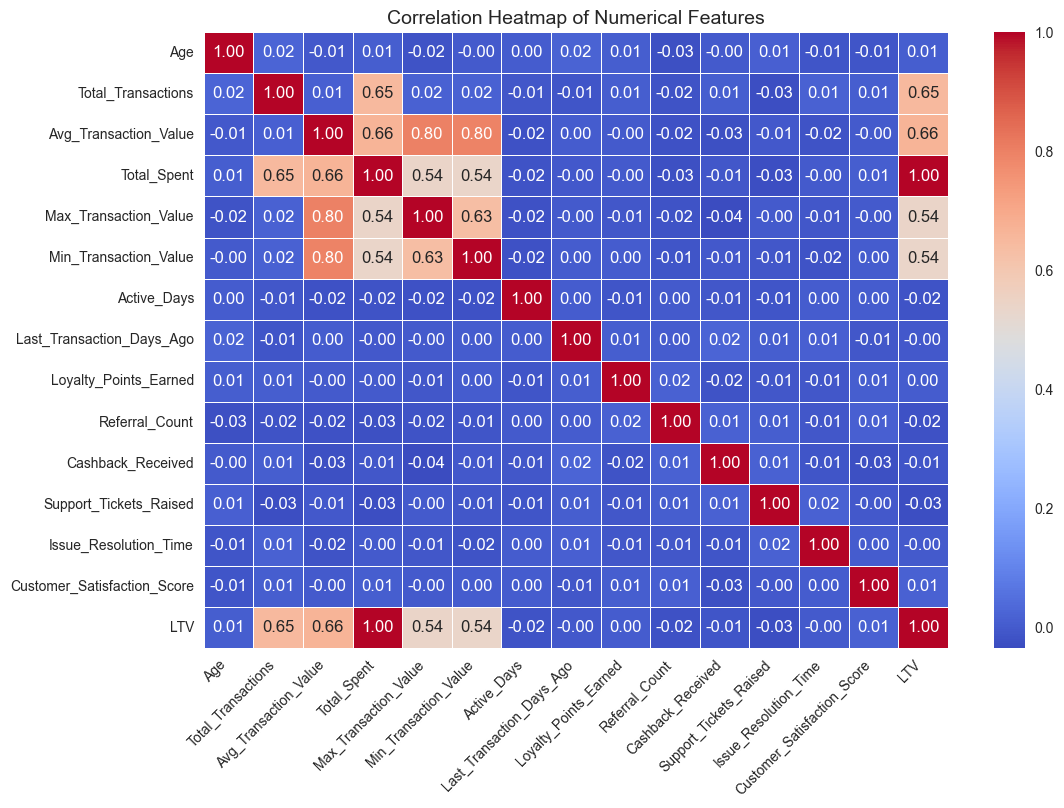

In [9]:
corr_matrix = df[num_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

#### Insights: <a id='corr_matrix'></a>
* Perhatikan bahwa fitur yang berkaitan dengan `Transactions` memiliki korelasi yang tinggi satu sama lain, terutama pada `LTV` dengan `Total_Spent` yang memiliki korelasi pearson sebesar 100%. Hal ini menandakan bahwa perhitungan nilai LTV sangat kuat dipengaruhi oleh nilai `Total_Transactions`.
* Di lain sisi, terlihat bahwa loyalty points tidak dipengaruhi dengan kuat atau moderat oleh fitur numerik lainnya

### 4.3.2 Analisis Distribusi Data

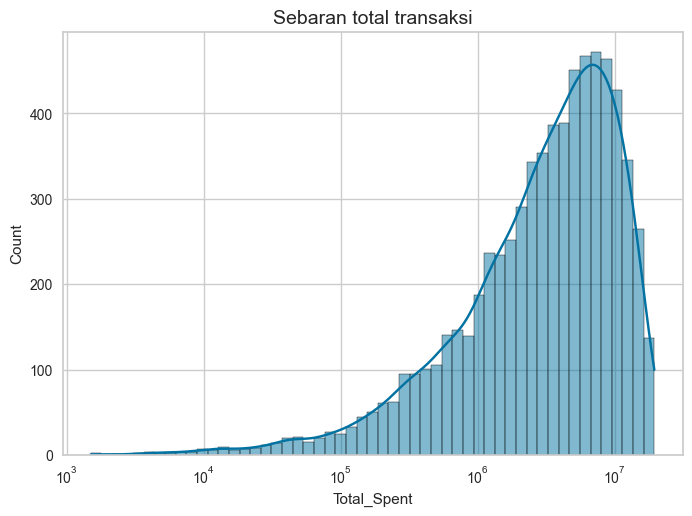

In [10]:
sns.histplot(data=df, x=df['Total_Spent'], kde=True, log_scale=True)
plt.title("Sebaran total transaksi", fontsize=14)
plt.show()

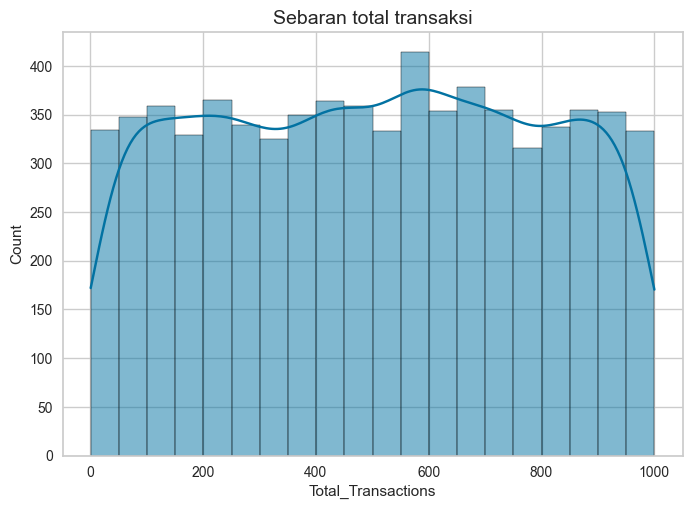

In [11]:
sns.histplot(data=df, x=df['Total_Transactions'], kde=True)
plt.title("Sebaran total transaksi", fontsize=14)
plt.show()

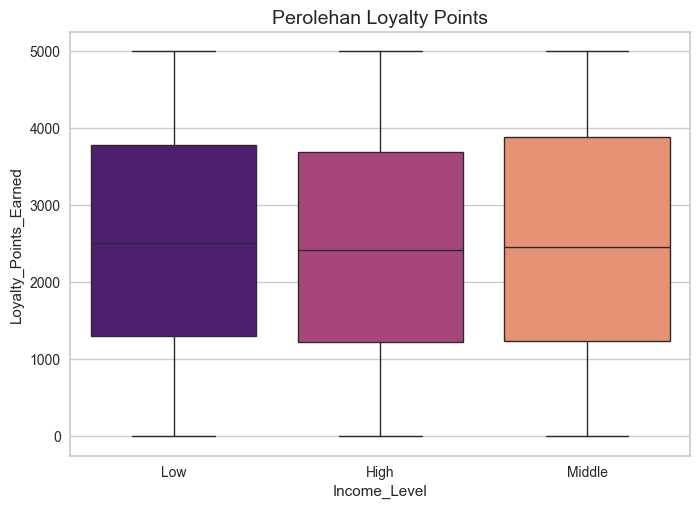

In [12]:
sns.boxplot(data=df, y=df['Loyalty_Points_Earned'], x=df['Income_Level'], hue=df['Income_Level'], palette="magma")
plt.title("Perolehan Loyalty Points", fontsize=14)
plt.show()

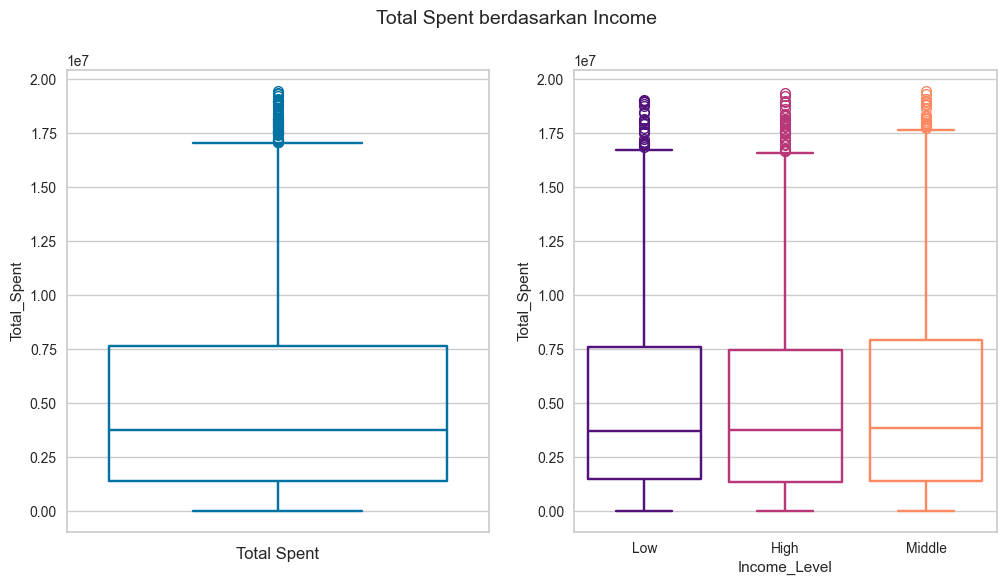

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
plt.suptitle("Total Spent berdasarkan Income", fontsize=14)

sns.boxplot(data=df, y=df['Total_Spent'], fill=False, ax=ax1)
ax1.set_xlabel("Total Spent", fontsize=12)

sns.boxplot(data=df, y=df['Total_Spent'], x=df['Income_Level'], hue='Income_Level',  fill=False, ax=ax2, palette="magma")
plt.show()

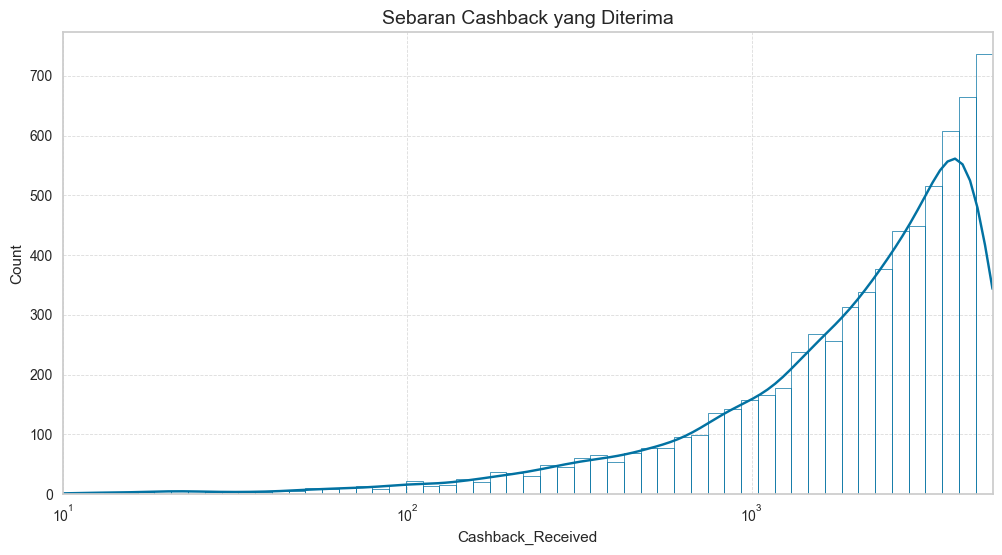

In [14]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=df, x='Cashback_Received', kde=True, log_scale=True, fill=False) 
ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
plt.title("Sebaran Cashback yang Diterima", fontsize=14)

ax.set_xlim(10, df['Cashback_Received'].max()) 
plt.show()

#### Insights
* Perhatikan sebaran Total Transaksi yang left skewed, Sebaran Cashback yang left skewed dengan mode yang berada di ujung kanan tetapi memiliki range x axis yang berbeda. **Mengartikan bahwa Standarisasi Data perlu dilakukan untuk bisa mendapatkan skala yang sama dengan sebaran normal standar**
* Perhatikan histogram Total Transaksi. Frekuensi total transaksi yang tersebar fluktuatif pada range 0-1000, yang juga menandakan perlu adanya standarisasi Data.
* Perhatikan Boxplot Loyalty Points, didapat bahwa tidak ada outlier dan tersebar cukup seimbang diatara kategori Income_Level. Juga tidak terdapat outlier pada loyalty Points. Ini menadakan bahwa **tidak perlu penanganan outlier**
* Perhatikan boxplot Total Spent berdasarkan Income, didapatkan bahwa Total Spent secara keseluruhan tidak memiliki outlier, tetapi bila dilihat dengan kategorisasi menggunakan income_level, didapat adanya outlier. secara umum, disimpulkan bahwa **tidak perlu penanganan outlier**

# 5. Data Preprocessing

## 5.1 Menghapus atau Menangani Data kosong

In [15]:
df.isna().sum()

Customer_ID                    0
Age                            0
Location                       0
Income_Level                   0
Total_Transactions             0
Avg_Transaction_Value          0
Max_Transaction_Value          0
Min_Transaction_Value          0
Total_Spent                    0
Active_Days                    0
Last_Transaction_Days_Ago      0
Loyalty_Points_Earned          0
Referral_Count                 0
Cashback_Received              0
App_Usage_Frequency            0
Preferred_Payment_Method       0
Support_Tickets_Raised         0
Issue_Resolution_Time          0
Customer_Satisfaction_Score    0
LTV                            0
dtype: int64

tidak ada missing values sehingga tidak perlu ditangani apa apa

## 5.2 Menangani Data Duplikat

untuk menangani data duplikat, hanya perlu melihat `Customer_ID` saja karena pad fitur lainnya, data duplikat tidak menjadi masalah

In [16]:
df['Customer_ID'].duplicated().sum()

0

tidak ada data duplikat sehingga tidak perlu ditangani apa apa

## 5.3 Normalisasi atau Standarisasi Fitur

Akan dilakukan standarisasi pada fitur numerik untuk menyeimbangkan skala yang ada antara satu fitur dengan fitur lainnya

In [17]:
scaler = StandardScaler()
scaled_num = scaler.fit_transform(df[num_features])
scaled_num_df = pd.DataFrame(scaled_num, columns=num_features)

Tidak dilakukan Normalisasi karena tidak membantu proses pembentukan cluster

## 5.4 Deteksi dan Penanganan Outlier

Untuk menangani Outlier, outlier akan dibatasi ke batas atas atau batas bawah IQR

In [18]:
def cap_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

df = cap_outliers_iqr(df, num_features)

## 5.4 Encoding Data Kategorikal

Dilakukan One Hot Encoding pada fitur kategorik karena label encoder tidak berarti banyak bagi model clusterisasi

In [19]:
encoder = OneHotEncoder(drop='first')
encoded_cat = encoder.fit_transform(df[cat_features])
encoded_cat_df = pd.DataFrame(encoded_cat.toarray(), columns=encoder.get_feature_names_out(cat_features))

processed_df = pd.concat([scaled_num_df, encoded_cat_df], axis=1)

## 5.5 Binning (Pengelompokkan Data)

Binning dalam hal ini ditujukan untuk keperluan EDA, bukan untuk clustering. Ini dilakukan sebagai pembanding antara binning dengan hasil cluster

In [20]:
bins_tot_trans = np.linspace(df['Total_Transactions'].min(), df['Total_Transactions'].max(), num=6) 
bins_tot_spent = np.linspace(df['Total_Spent'].min(), df['Total_Spent'].max(), num=6)
bins_tot_loyal = np.linspace(df['Loyalty_Points_Earned'].min(), df['Loyalty_Points_Earned'].max(), num=6)

df_num = df[num_features]
df_num['bin_total_transaction'] = pd.cut(df_num['Total_Transactions'], bins=bins_tot_trans)
df_num['bin_total_spent'] = pd.cut(df_num['Total_Spent'], bins=bins_tot_spent)
df_num['bin_total_loyal'] = pd.cut(df_num['Loyalty_Points_Earned'], bins=bins_tot_loyal)

C:\Users\Ghiffari\AppData\Local\Temp\ipykernel_20380\3701561848.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['bin_total_transaction'] = pd.cut(df_num['Total_Transactions'], bins=bins_tot_trans)
C:\Users\Ghiffari\AppData\Local\Temp\ipykernel_20380\3701561848.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['bin_total_spent'] = pd.cut(df_num['Total_Spent'], bins=bins_tot_spent)
C:\Users\Ghiffari\AppData\Local\Temp\ipykernel_20380\3701561848.py:8: SettingWithCopyWarning: 
A value is try

C:\Users\Ghiffari\AppData\Local\Temp\ipykernel_20380\2812698342.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, fontsize=8)
C:\Users\Ghiffari\AppData\Local\Temp\ipykernel_20380\2812698342.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[0].get_xticklabels(), rotation=45, fontsize=8)
C:\Users\Ghiffari\AppData\Local\Temp\ipykernel_20380\2812698342.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[0].get_xticklabels(), rotation=45, fontsize=8)


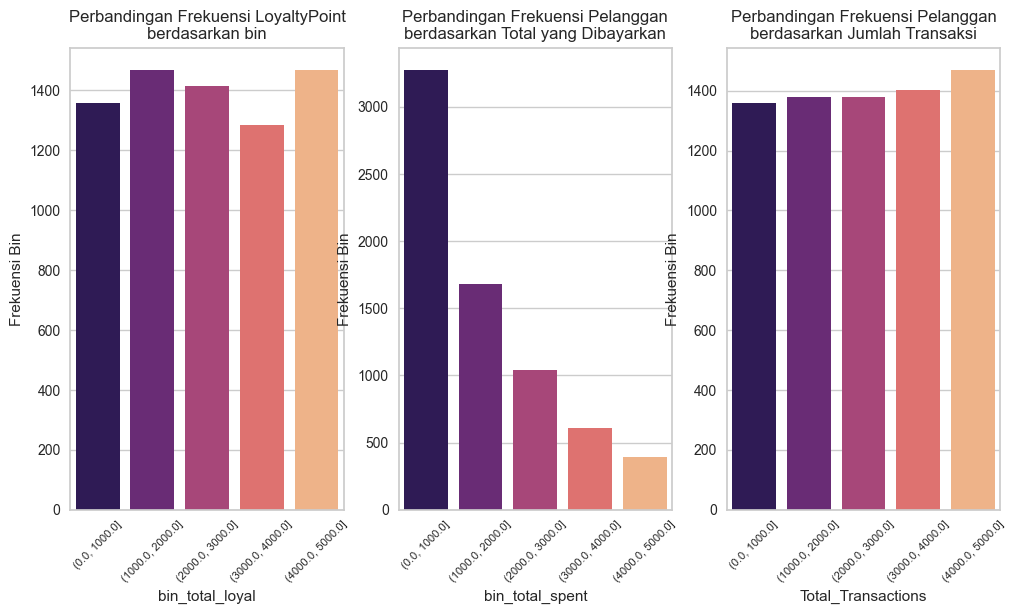

In [21]:
binned = ['bin_total_loyal', 'bin_total_spent', 'bin_total_loyal']
fig, ax = plt.subplots(1,3, figsize=(12,6))

df_num_1 = df_num.groupby('bin_total_loyal').agg('count')
sns.barplot(df_num_1, x='bin_total_loyal', y='Age', ax=ax[0], palette="magma")
ax[0].set_title("Perbandingan Frekuensi LoyaltyPoint\nberdasarkan bin")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, fontsize=8)
ax[0].set_ylabel("Frekuensi Bin")

df_num_2 = df_num.groupby('bin_total_spent').agg('count')
sns.barplot(df_num_2, x='bin_total_spent', y='Age', ax=ax[1], palette="magma")
ax[1].set_title("Perbandingan Frekuensi Pelanggan\nberdasarkan Total yang Dibayarkan")
ax[1].set_xticklabels(ax[0].get_xticklabels(), rotation=45, fontsize=8)
ax[1].set_ylabel("Frekuensi Bin")

df_num_2 = df_num.groupby('bin_total_transaction').agg('count')
sns.barplot(df_num_2, x='Total_Transactions', y='Age', ax=ax[2], palette="magma")
ax[2].set_title("Perbandingan Frekuensi Pelanggan\nberdasarkan Jumlah Transaksi")
ax[2].set_xticklabels(ax[0].get_xticklabels(), rotation=45, fontsize=8)
ax[2].set_ylabel("Frekuensi Bin")

plt.show()

#### Insights:
* Telah dilakukan preprocessing data dengan standarisasi, pembatasan nilai outlier, dan encoding data kategorikan sehingga didapat 
* Perhatikan bahwa sebaran data hasil binning terlihat berbeda beda, berdasarkan loyalty point dan jumlah transaksi, didapat bahwa sebarannya cukup rata, sementara sebaran berdasarkan total yang dibayarkan memiliki sebaran right-skewed. Clustering menjadi tantangan dalam hal ini, karena sebarannya cukup berbeda bila dipengaruhi oleh total_spent

# 6. Pembangunan Model Clustering

## 6.1 Pembangunan Model Clustering

dalam hal ini, akan dibuat model clustering berdasarkan metode yang ditentukan

### 6.1.1 Model Clustering dengan seluruh Fitur

Dengan perspektif mencari k optimal berdasarkan silhouette terbesar. Selain itu, digunakan juga berdasarkan KElbowVisualizer seperti terlihat pada output dibawah

Optimal k: 2, Final Silhouette Score: 0.1451 




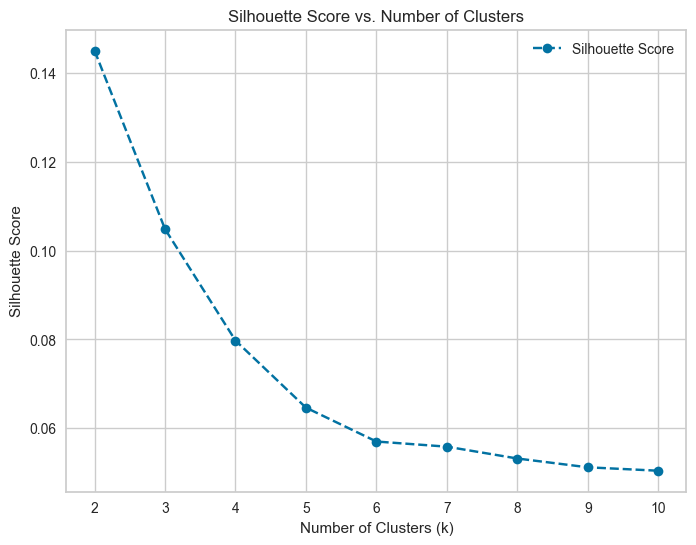

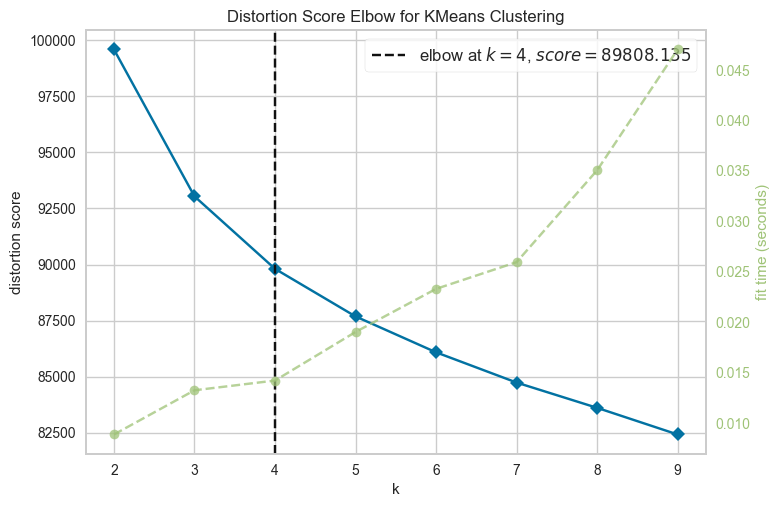

Optimal number of clusters (K): 4


In [36]:
model = {}
silhouette_scores = {}
inertia = []
sil_scores = []
K_range = range(2, 11)
kmeans_df = processed_df.copy()

def kmeans_without_pca(kmeans_df, K_range):
    for k in K_range:
        kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=10)
        kmeans.fit(kmeans_df)
        inertia.append(kmeans.inertia_)
        sil_scores.append(silhouette_score(kmeans_df, kmeans.labels_))
    
    optimal_k = K_range[np.argmax(sil_scores)]
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(kmeans_df)
    final_silhouette = silhouette_score(kmeans_df, kmeans_labels)
    silhouette_scores["K-Means tanpa PCA"] = final_silhouette
    model["K-Means tanpa PCA"] = [kmeans, kmeans_labels]
    print(f"Optimal k: {optimal_k}, Final Silhouette Score: {final_silhouette:.4f} \n\n")
    
    plt.figure(figsize=(8, 6))
    plt.plot(K_range, sil_scores, marker='o', linestyle='--', color='b', label='Silhouette Score')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.legend()
    plt.show()

def visualizer_model(kmeans_df, k):
    visualizer = KElbowVisualizer(KMeans(random_state=42), k=k)
    visualizer.fit(kmeans_df) 
    visualizer.show()
    optimal_k = visualizer.elbow_value_
    print(f"Optimal number of clusters (K): {optimal_k}")

kmeans_without_pca(kmeans_df, K_range)
visualizer_model(kmeans_df, k=(2,10))

### 6.1.2 Model Clustering dengan menggunakan PCA dari seluruh fitur

berikut ini dibangun model menggunakan PCA (principal component analysis) dari seluruh fitur pada `processed_df` dengan n_components = 2

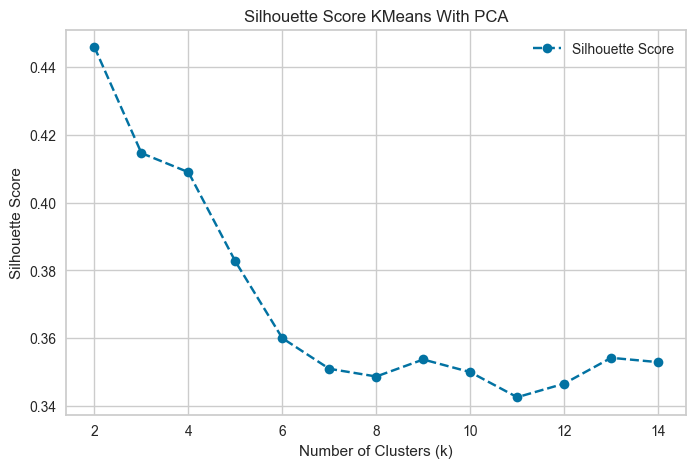

Optimal k: 2, Final Silhouette Score: 0.4458 




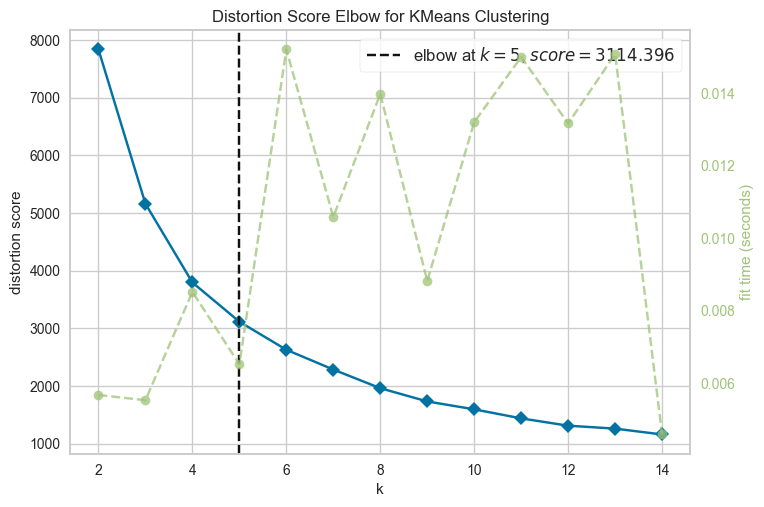

Optimal number of clusters (K): 5


In [35]:
def kmeans_with_pca(kmeans_df, K_range):
    sil_scores = []
    kmeans_df = processed_df.copy()
    scaler = RobustScaler()
    df_scaled = scaler.fit_transform(kmeans_df)

    pca = PCA(n_components=2)  
    df_pca = pca.fit_transform(df_scaled)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)  
        kmeans.fit(df_pca)
        
        labels = kmeans.labels_
        inertia.append(kmeans.inertia_)
        sil_scores.append(silhouette_score(df_pca, labels))
    
    optimal_k = K_range[np.argmax(sil_scores)]
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=30)
    kmeans_labels = kmeans.fit_predict(df_pca)
    final_silhouette = silhouette_score(df_pca, kmeans_labels)
    
    silhouette_scores["K-Means dengan PCA dan Robust Scaler"] = final_silhouette
    model["K-Means dengan PCA n_components = 2"] = [kmeans, kmeans_labels]
    
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, sil_scores, marker='o', linestyle='--', color='b', label='Silhouette Score')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score KMeans With PCA')
    plt.legend()
    plt.show()

    print(f"Optimal k: {optimal_k}, Final Silhouette Score: {final_silhouette:.4f} \n\n")

    return df_pca

def visualizer_model(kmeans_df, k):
    visualizer = KElbowVisualizer(KMeans(random_state=42), k=k)
    visualizer.fit(kmeans_df) 
    visualizer.show()
    optimal_k = visualizer.elbow_value_
    print(f"Optimal number of clusters (K): {optimal_k}")

df_pca = kmeans_with_pca(kmeans_df, K_range=range(2,15))
visualizer_model(df_pca, k=(2,15))

## 6.2 Evaluasi Model Clustering

Evaluasi model clustering digabung pada bagian 6.1. Selanjutnya perhatikan 2 output sebelumnya. Didapat bahwa:
* Model 6.1.1 yang melakukan clusterisasi **tanpa adanya PCA dan Robust scaling** mendapatkan silhouette score sebesar 0.1451 dengan optimal k berdasar silhouette score adalah 2, sementara optimal k berdasar Elbow methods adalah 4
* Model 6.1.2 yang melakukan clusterisasi melalui **PCA dan Robust Scaling** mendapatkan silhouette score lebih tinggi yakni 0.4458 dengan optimal k berdasar silhouette score adalah 2, sementara optimal k berdasar Elbow methods adalah 5

## 6.3 Feature Selection

Perhatikan correlation matrix, didapat bahwa 

In [ ]:
processed_df = processed_df[["Total_Spent",'LTV']]

In [ ]:
X = processed_df.copy()
pca = PCA().fit(X)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

optimal_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Optimal number of PCA components: {optimal_components}")

pca = PCA(n_components=optimal_components)
X_pca = pca.fit_transform(X)

kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)
silhouette_pca = silhouette_score(X_pca, clusters_pca)
print(f"Silhouette Score (After PCA): {silhouette_pca:.4f}")

In [ ]:
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2, 10))
visualizer.fit(processed_df) 
visualizer.show()
optimal_k = visualizer.elbow_value_
print(f"Optimal number of clusters (K): {optimal_k}")

In [ ]:
variance_selector = VarianceThreshold(threshold=0.01) 
processed_high_variance = variance_selector.fit_transform(processed_df)  

scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_high_variance)

pca = PCA(n_components=2) 
transformed_data = pca.fit_transform(scaled_data)

optimal_k = 2  
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=30)
kmeans.fit(transformed_data)

all_clusters = kmeans.predict(transformed_data)

processed_df["Cluster"] = all_clusters
print(processed_df.head())

In [ ]:
processed_df = processed_df[:]
variance_selector = VarianceThreshold(threshold=0.01)  
processed_high_variance = variance_selector.fit_transform(processed_df) 

scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_high_variance)

pca = PCA(n_components=2) 
transformed_data = pca.fit_transform(scaled_data)

optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=30)
kmeans.fit(transformed_data)

all_clusters = kmeans.predict(transformed_data)

processed_df["Cluster"] = all_clusters
print(processed_df.head())

In [ ]:
transformed_data.shape

In [ ]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(transformed_data, all_clusters)
print(f"Silhouette Score: {sil_score:.4f}")